In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LEVEL 1/torch')
from multiclass_functions1 import * # all
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cpu


In [ ]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
new_model_train = False
model_type = "MLP"
dataset = "MNIST"
save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}_shuffle.pt"

In [ ]:
def shuffle_pixels(img):
    # 랜덤 시드 고정
    torch.manual_seed(42)

    # (C, H, W) 형태에서 flatten
    flat_img = img.flatten()  # (C * H * W)

    # torch.randperm을 사용하여 랜덤 순서 생성
    perm = torch.randperm(flat_img.shape[0])  # (C * H * W)의 랜덤 인덱스

    # 인덱스를 기반으로 텐서 값 섞기
    shuffled_img = flat_img[perm]  # 섞은 순서로 재배치

    # 원래 형상 복원
    shuffled_img = shuffled_img.reshape(img.shape)  # (C, H, W)

    return shuffled_img

transform = transforms.Compose([
    transforms.ToTensor(), # 이미지를 Tensor로 변환 (C, H, W)
    shuffle_pixels, # 픽셀 섞기 함수 적용
])

In [ ]:
train_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

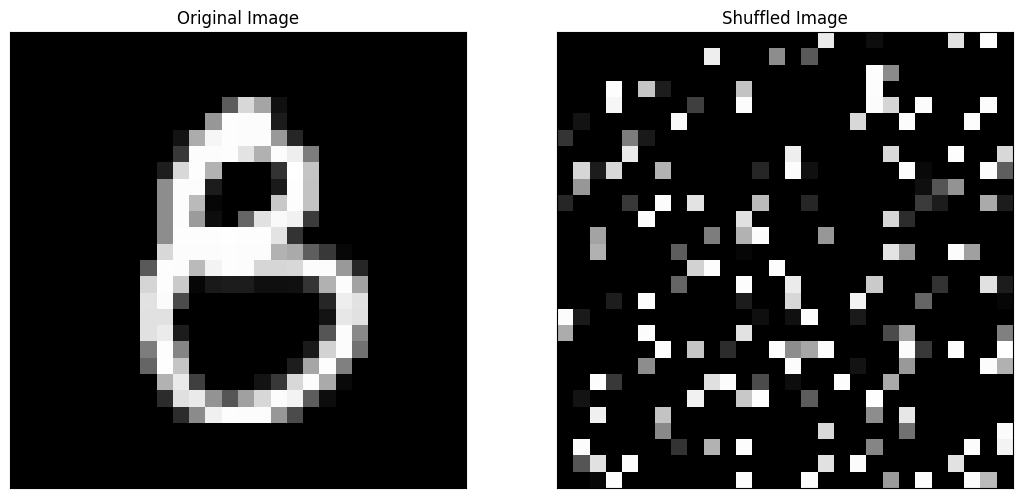

In [ ]:
def show_images_before_after(original, shuffled):

    plt.figure(figsize=(20,15))

    plt.subplot(2,3,1, xticks=[], yticks=[])
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")

    plt.subplot(2,3,2, xticks=[], yticks=[])
    plt.imshow(shuffled, cmap='gray')
    plt.title("Shuffled Image")

# 데이터 하나 가져오기
original_img = test_DS.data[800]

# 섞은 이미지 생성
shuffled_img = shuffle_pixels(original_img)

# 섞기 전과 후의 이미지 비교
show_images_before_after(original_img, shuffled_img)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs = nn.Sequential(nn.Linear(28*28, 30),
                                 nn.BatchNorm1d(30),
                                 nn.ReLU(),
                                 nn.Linear(30, 10))
    def forward(self,x):
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x

In [ ]:
model = globals()[model_type]().to(DEVICE)
print(model)

x_batch, _ = next(iter(train_DL))
print(x_batch.shape)

model.eval()
with torch.no_grad():
    print(model(x_batch.to(DEVICE)).shape)

MLP(
  (fcs): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=10, bias=True)
  )
)
torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr = LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.plot(range(1,EPOCH+1),loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.grid()

In [ ]:
load_model = torch.load(save_model_path, map_location=DEVICE, weights_only=False)

In [ ]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 9605/10000 (96.0 %)
23920


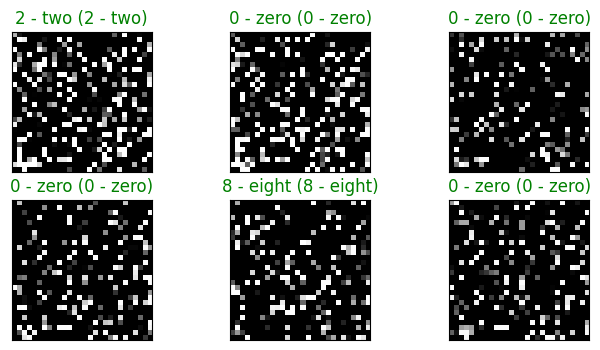

In [ ]:
Test_plot(load_model, test_DL)

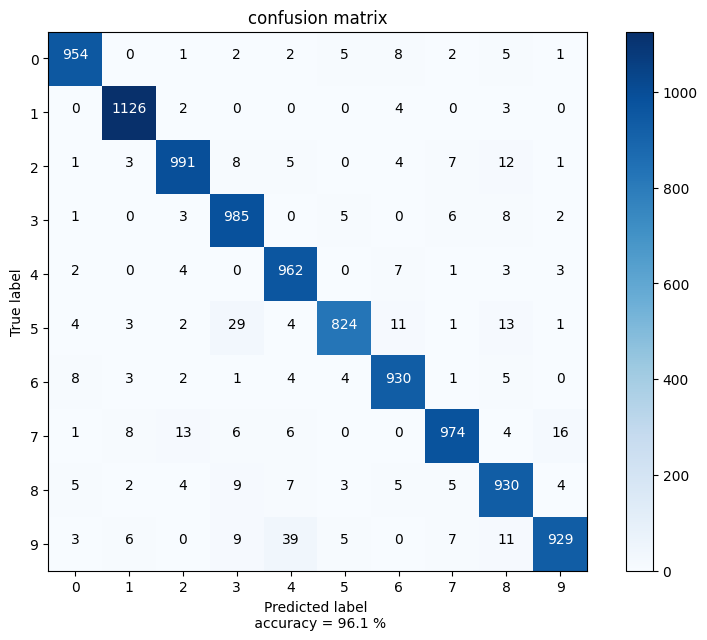

In [ ]:
confusion = get_conf(load_model, test_DL)
plot_confusion_matrix(confusion, test_DS.classes)
plt.xticks(rotation=45);

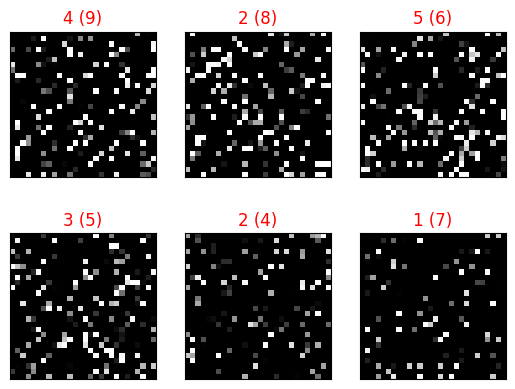

In [ ]:
# 틀린 것만 모아서 보자
cnt = 0
load_model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_DL:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        y_hat = load_model(x_batch)
        pred = y_hat.argmax(dim=1)

        false_idx = pred!=y_batch
        X_false=x_batch[false_idx,...].to("cpu")
        pred_false=pred[false_idx,...].to("cpu")
        Y_false=y_batch[false_idx,...].to("cpu")

        if X_false.shape[0] != 0:
            if cnt==6:
                break
            for i in range(X_false.shape[0]):
                cnt += 1
                pred_class = pred_false[i].item()
                true_class = Y_false[i].item()
                plt.subplot(2,3, cnt, xticks=[], yticks=[])
                plt.imshow(X_false[i,0,...], cmap="gray")
                plt.title(f"{pred_class} ({true_class})",color=("g" if pred_class==true_class else "r"))
                if cnt==6:
                    break